## Download dataset

In [3]:
# method1. upload dataset manually (very slow)
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# method 2. faster way using kaggle command ( please check https://www.kaggle.com/general/74235)

#1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

#2. Click on Create New API Token - It will download kaggle.json file on your machine.

#3. Go to your Google Colab project file and run the following commands:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pwd

/content


In [6]:
# unzip dataset
!kaggle competitions download -c computer-vision-hw4
!unzip computer-vision-hw4.zip
!ls -alh

Streaming output truncated to the last 5000 lines.
  inflating: ccpd6000/test_images/1009.jpg  
  inflating: ccpd6000/test_images/1010.jpg  
  inflating: ccpd6000/test_images/1011.jpg  
  inflating: ccpd6000/test_images/1012.jpg  
  inflating: ccpd6000/test_images/1013.jpg  
  inflating: ccpd6000/test_images/1014.jpg  
  inflating: ccpd6000/test_images/1015.jpg  
  inflating: ccpd6000/test_images/1016.jpg  
  inflating: ccpd6000/test_images/1017.jpg  
  inflating: ccpd6000/test_images/1018.jpg  
  inflating: ccpd6000/test_images/1019.jpg  
  inflating: ccpd6000/test_images/1020.jpg  
  inflating: ccpd6000/test_images/1021.jpg  
  inflating: ccpd6000/test_images/1022.jpg  
  inflating: ccpd6000/test_images/1023.jpg  
  inflating: ccpd6000/test_images/1024.jpg  
  inflating: ccpd6000/test_images/1025.jpg  
  inflating: ccpd6000/test_images/1026.jpg  
  inflating: ccpd6000/test_images/1027.jpg  
  inflating: ccpd6000/test_images/1028.jpg  
  inflating: ccpd6000/test_images/1029.jpg  
  in

In [7]:
# !sudo kill -9 0
!nvidia-smi


Mon Dec 26 19:02:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import warnings

import torch
import numpy as np
from PIL import Image, ImageDraw
from skimage import util
from skimage.transform import ProjectiveTransform, warp

def draw_kpts(img, kpts, c='red', r=2.0):
    '''Draw keypoints on image.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
        c: (PIL.Color) color of keypoints, default to 'red'
        r: (float) radius of keypoints, default to 2.0
    Return:
        img: (PIL.Image) modified image
    '''
    draw = ImageDraw.Draw(img)
    kpts = kpts.view(4, 2)
    kpts = kpts * torch.FloatTensor(img.size)
    kpts = kpts.numpy().tolist()
    for (x, y) in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img


def draw_plate(img, kpts):
    '''Perspective tranform and draw the plate indicated by kpts to a 96x30 rectangle.
    Args:
        img: (PIL.Image) will be modified
        kpts: (FloatTensor) keypoints in xy format, sized [8,]
    Return:
        img: (PIL.Image) modified image
    Reference: http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    '''
    src = np.float32([[96, 30], [0, 30], [0, 0], [96, 0]])
    dst = kpts.view(4, 2).numpy()
    dst = dst * np.float32(img.size)

    transform = ProjectiveTransform()
    transform.estimate(src, dst)
    with warnings.catch_warnings(): # surpress skimage warning
        warnings.simplefilter("ignore")
        warped = warp(np.array(img), transform, output_shape=(30, 96))
        warped = util.img_as_ubyte(warped)
    plate = Image.fromarray(warped)
    img.paste(plate)
    return img

# Init and Utility

In [9]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

In [10]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img



# Training Data

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


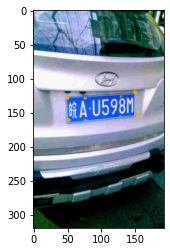

In [11]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.img_paths = self.img_dir.glob('*.jpg')
        self.img_paths = sorted(list(self.img_paths))

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img_path = self.img_paths[idx]

        # load image
        img = Image.open(img_path)
        W, H = img.size
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        
        # parse annotation
        kpt = self.anns[idx]
        kpt = list(kpt.values())[1:9]
        kpt = torch.tensor(kpt) # [8,]
        kpt = kpt.view(4, 2) # [4, 2]
        kpt = kpt / torch.FloatTensor([W, H])
        kpt = kpt.view(-1) # [8,]
        
        return img, kpt


# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000

img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

# Network

In [12]:
from torchvision.models import resnet18
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary

        # TODO : add more layers to achieve better performance
        self.features = resnet18()
        self.features.fc = nn.Linear(512, 512)

        # TODO : add ouput layer to predict position
        self.regression = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
        )
    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
        features = self.features(img_b)
        # 163840x6 and 8192x1024)
        features = features.view(features.size()[0], -1)
        kpt_b = self.regression(features)
      
        return kpt_b
# Do some checking
loader = DataLoader(data, batch_size=32) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]



# Do a forwarding
# device = 'gpu'     # the computing device, 'cuda' or 'cpu'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'Tesla T4'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)

loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([32, 3, 320, 192])
torch.Size([32, 8])
tensor(0.4421, device='cuda:0', grad_fn=<MeanBackward0>)


# Training

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


lr: 0.0009
Epoch 000:
train loss: 0.07259018348219494
valid loss: 0.06212865908940633
train mse: 0.011177825763782796
valid mse: 0.006591795974721511
lr: 0.0009
Epoch 001:
train loss: 0.05609712031049033
valid loss: 0.04645799305289984
train mse: 0.005329000505541141
valid mse: 0.0037936910734667133
lr: 0.0009
Epoch 002:
train loss: 0.03865861870969335
valid loss: 0.028308521614720424
train mse: 0.002619535456324229
valid mse: 0.0015005138576574004
lr: 0.0009
Epoch 003:
train loss: 0.02871118882903829
valid loss: 0.033846105262637136
train mse: 0.00144192955243246
valid mse: 0.001760228886269033
lr: 0.00045
Epoch 004:
train loss: 0.025355198544760545
valid loss: 0.02577622883642713
train mse: 0.0011044743439318457
valid mse: 0.0012074921134626493
lr: 0.00045
Epoch 005:
train loss: 0.01896192420972511
valid loss: 0.01398402575093011
train mse: 0.0006542634723397593
valid mse: 0.0003663626470370218
lr: 0.00045
Epoch 006:
train loss: 0.016987505023522923
valid loss: 0.01326042003929615
tr

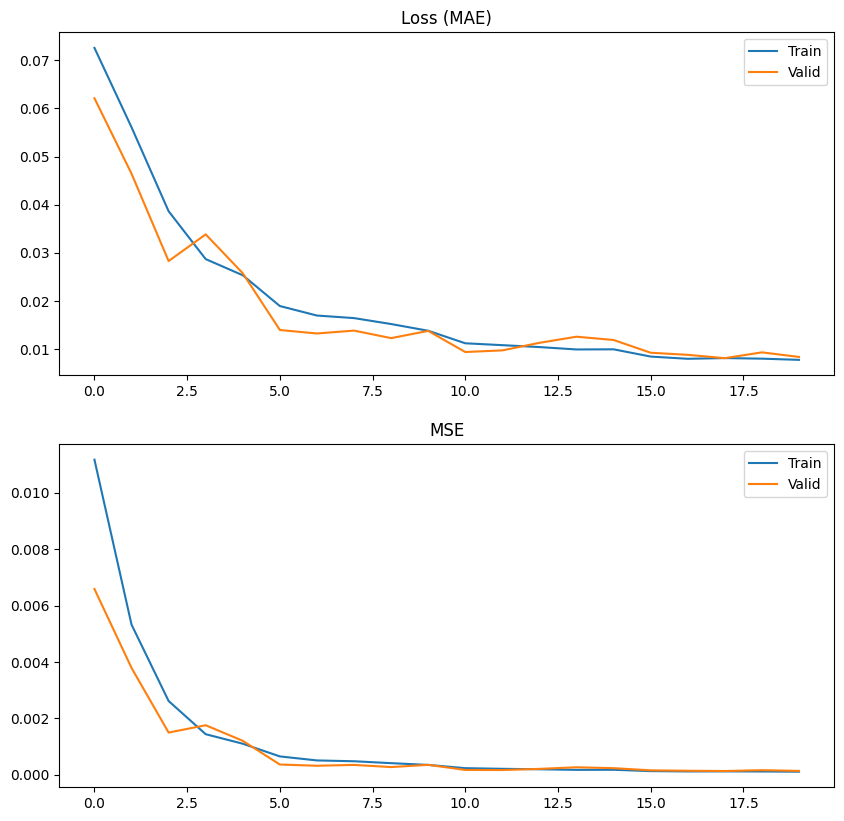

In [13]:
import torch.optim.lr_scheduler
import os

class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True, num_workers=4)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False, num_workers=4)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        # self.device = 'gpu'
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # selfdevice = 'Tesla T4'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=9e-4)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.5, last_epoch=-1)

        #TODO define your training epochs
        self.max_epoch = 20

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': [], 'train_mse': [], 'valid_mse': []}

        for self.epoch in range(self.max_epoch): # epochs
            train_loss, train_mse = self.train() # train 1 epoch
            valid_loss, valid_mse = self.valid() # valid 1 epoch
            self.visul()              # visualization
            print('lr:',get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            print('train mse:', train_mse)
            print('valid mse:', valid_mse)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            metrics['train_mse'].append(train_mse)
            metrics['valid_mse'].append(valid_mse)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_mse']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))

        # Plot the loss curve against epoch
        fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
        ax[0].set_title('Loss (MAE)')
        ax[0].plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax[0].plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax[0].legend()
        ax[1].set_title('MSE')
        ax[1].plot(range(self.epoch + 1), metrics['train_mse'], label='Train')
        ax[1].plot(range(self.epoch + 1), metrics['valid_mse'], label='Valid')
        ax[1].legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.train_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            self.optimizer.zero_grad()
            pred_b = self.model(img_b)

            # TODO 
            # step 1 caculate the loss 
            loss = self.criterion(pred_b, kpt_b)
            # step 2 back propagation
            loss.backward()
            # step 3 update parameters using optimizer
            self.optimizer.step()


            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)

        self.scheduler.step()

        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        mse_steps = []

        for img_b, kpt_b in iter(self.valid_loader):
            img_b = img_b.to(self.device)
            kpt_b = kpt_b.to(self.device)
            pred_b = self.model(img_b)
            loss = self.criterion(pred_b, kpt_b)
            loss_steps.append(loss.detach().item())
            mse = F.mse_loss(pred_b.detach(), kpt_b.detach()).item()
            mse_steps.append(mse)

        avg_loss = sum(loss_steps) / len(loss_steps)
        avg_mse = sum(mse_steps) / len(mse_steps)
        return avg_loss, avg_mse

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir.mkdir(parents=True)
Trainer(log_dir).run()

# Testing

In [14]:
# Do testing
from pathlib import Path
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as tf

#import utils
#from utils.model import CCPDRegressor
img_size=(192, 320)
class CCPDTest:
    def __init__(self, img_dir):
        img_paths = Path(img_dir).glob('*.jpg')
        self.img_paths = sorted(list(img_paths))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize((192, 320))
        img = tf.to_tensor(img)
        return img


test_set = CCPDTest('./ccpd6000/test_images')
test_loader = DataLoader(test_set, 32, shuffle=False, num_workers=2)

device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
# model.load_state_dict(torch.load('runs/Jan.14 11:12:28/training_result/model.pth'))
model.eval()

log_dir_test = Path('./testing_result') / f'{datetime.now():%b.%d %H:%M:%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

def test(pbar):
    model.eval()
    anns = []
    for img_b in iter(test_loader):
        kpt_b = model(img_b.to(device)).cpu()

        for img, kpt in zip(img_b, kpt_b):
            img = tf.to_pil_image(img)
            vis = draw_plate(img, kpt)
            vis = draw_kpts(vis, kpt, c='red')
            vis.save(log_dir_test / f'{pbar.n:03d}_vis.jpg')
            # Original image size: 720 * 1160
            # print(kpt)
            # print(kpt[0:-1:2])
            # print(kpt[1::2])
            kpt[0:-1:2] *= 720
            kpt[1::2] *= 1160
            anns.append([f'{pbar.n:04d}.jpg', *kpt.numpy().tolist()])
            pbar.update()

    return pd.DataFrame(anns)

with torch.no_grad():
    with tqdm(total=len(test_set)) as pbar:
        df_pred = test(pbar)
    df_pred.columns = ['name', 'BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y']
    df_pred.to_csv('./ccpd6000/test_pred.csv', float_format='%.5f', index=False)

testing_result/Dec.26 19:21:33


100%|██████████| 3000/3000 [01:18<00:00, 37.98it/s]


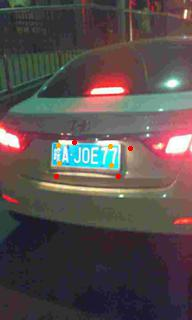

In [15]:
display.Image(str(log_dir / '001' / '026.jpg')) # A visualization of validation data in epoch 4

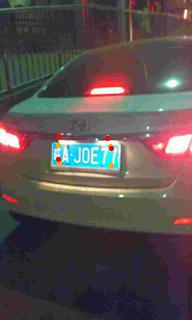

In [16]:
display.Image(str(log_dir / '003' / '026.jpg')) # A visualization of validation data in epoch 10

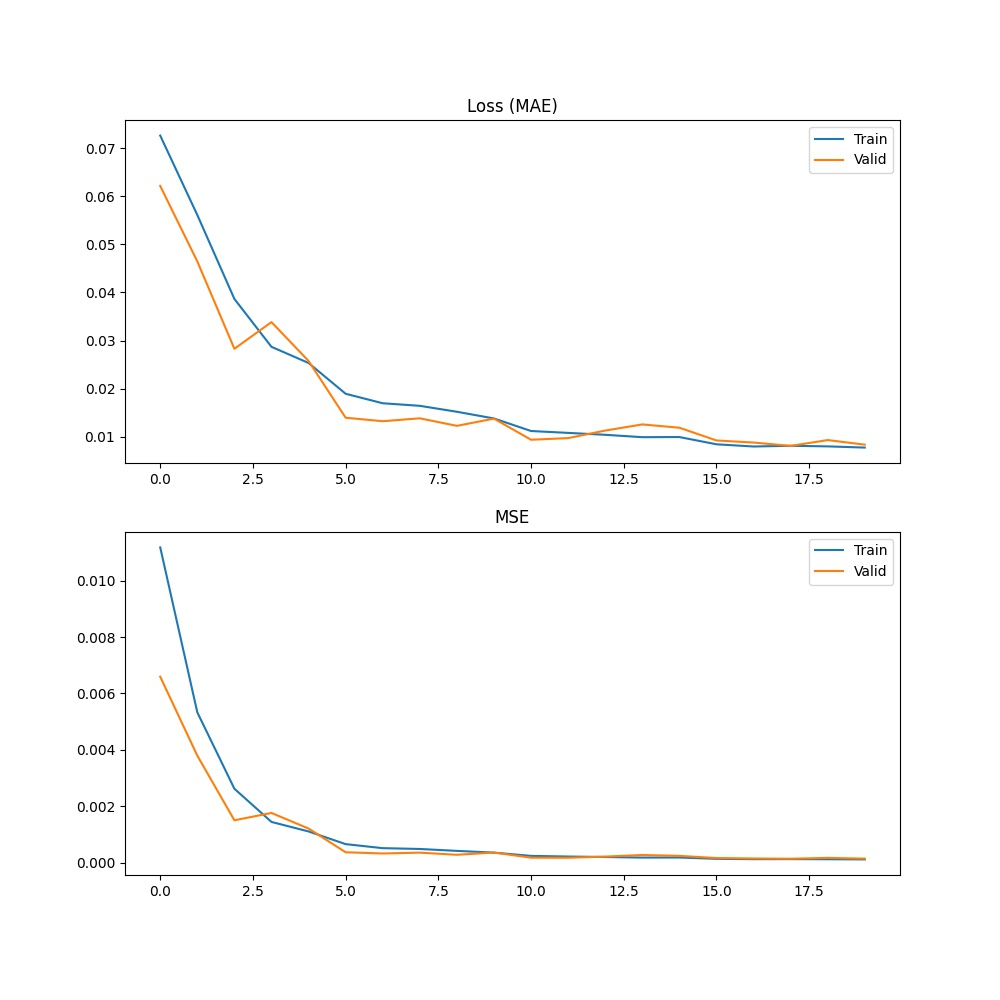

In [17]:
display.Image(str(log_dir / 'training_result/metrics.jpg')) # Loss

# Report
- learning rate
    - Learning Rate has a great influence on the learning of model gradient descent
        - Learning Rate is too small => easy to train slowly
        - Learning Rate is too large => easy to fail to converge
    - Therefore I used pytorch's function `lr_scheduler.StepLR` to adjust learning rate，

- TODO define your training epochs
    - Because of the adjustment of the learning rate, I did 20 epochs on the model.
    - (I also tried 30 epochs on the model, but there was no better performance.)

- TODO : add more layers to achieve better performance
    - Using the `resnet18()` network to extract features can reach the score of baseline (7 points).

- TODO : add ouput layer to predict position
    - Using the combination of `nn.ReLU()` and `nn.Linear()`,  and finally output 8 predict positions.

- TODO 
	- step 1 caculate the loss 
		- `loss = self.criterion(pred_b, kpt_b)`
	- step 2 back propagation
		- `loss.backward()`
	- step 3 update parameters using optimizer
		- `self.optimizer.step()`
- Others (check gpu)
  - `device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")`